# Spatial and temporal filtering of two-dimensional fields 

**context** : demonstration for AJ and LG on Jan 2017

**author** : J. Le Sommer (from a notebook by G. Serrazin)

**purpose** : show how to use linear filters from oocgcm 

## 0. required preliminary installations
from the bash shell, proceed to te following installation if you have not already : 
```bash
conda install numpy
conda install matplotlib
conda install xarray
pip install version_information
pip install seaborn
conda install -c conda-forge -c ioam geoviews
conda install -c https://conda.binstar.org/ioos cartopy
```
install oocgcm package from github: 
```bash
git clone https://github.com/lesommer/oocgcm.git
cd oocgcm/
python setup.py install --home=~
```

## 1. importing external modules

In [1]:
## magics
%load_ext version_information 
%version_information numpy,xarray

Software versions
Python 2.7.11 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 5.1.0
OS Darwin 15.5.0 x86_64 i386 64bit
numpy 1.11.2
xarray 0.8.2
Wed Jan 11 09:23:02 2017 CET

In [2]:
## standart libraries
import os,sys,user,glob
import numpy as np

## third party imports
import xarray as xr

#import pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline 
# doesnt work if put in previous block...

## local/specific imports
import oocgcm
import oocgcm.filtering.linearfilters as tf

## 2. using test dataset

The test dataset can be retrieved from https://www.dropbox.com/s/2wq18xivtrjyy52/ORCA025_SSH_SWPAC.nc?dl=0. Here, I have put the dataset in `$HOME/data/ORCA025`

In [3]:
sigdir = user.home + "/data/ORCA025/"
test_file = 'ORCA025_SSH_SWPAC.nc'
sigdir + test_file

'/Users/lesommer/data/ORCA025/ORCA025_SSH_SWPAC.nc'

This is an example of simulated sea surface height from the NEMO model run at 1/4°, that is represented by an xarray.DataArray object. Note that dask array can be used by precising chunks.


<xarray.DataArray 'sossheig' (time_counter: 300, y: 184, x: 224)>
dask.array<xarray-..., shape=(300, 184, 224), dtype=float64, chunksize=(50, 184, 224)>
Coordinates:
  * time_counter  (time_counter) float64 73.04 nan nan nan nan nan nan nan ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...


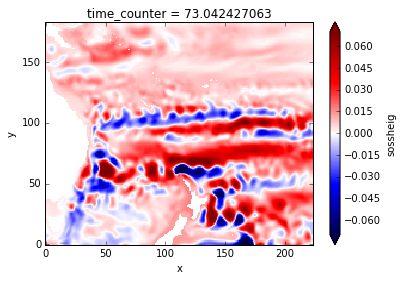

In [4]:
signal_xyt = xr.open_dataset(sigdir + test_file, decode_times=False,engine='scipy')['sossheig'].chunk(chunks={'time_counter': 50})
print signal_xyt
signal_xyt.isel(time_counter=0).plot(vmin=-0.07, vmax=0.07, cmap='seismic')

A window object that is linked to the previous data is created by the following line:


In [5]:
win1D = signal_xyt.win

## 3. Temporal filtering:


### Boxcar window



A boxcar window object that will be applied along the time dimension is simply be defined by setting its different properties:


In [6]:
win1D.set(window_name='boxcar', n=[5], dims=['time_counter'])
print win1D._depth.values()
print win1D

[5]
Window [name->boxcar,dims->['time_counter'],order->{'time_counter': 5}]


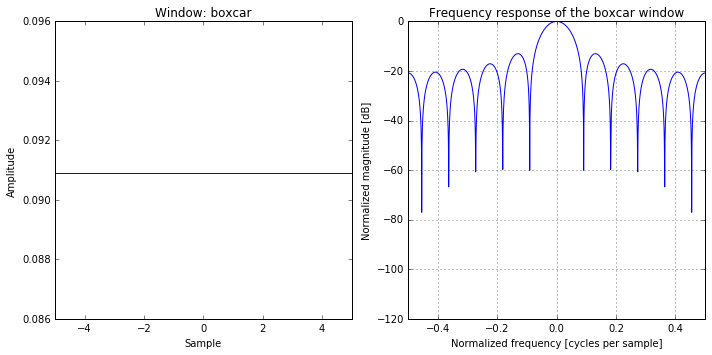

In [7]:
win1D.plot()

In [8]:
signal_LF_box = win1D.apply(compute=True)

[########################################] | 100% Completed |  0.7s


/Users/lesommer/anaconda2/lib/python2.7/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in divide
  if not reflexive


By default the filtering is computed when using the apply function. If compute is set to False, the filtering will be computed when the output data is required. This allows the definition of several dask object before the global computation is performed.


### Lanczos window


Setting now different properties to use a Lanczos window:


/Users/lesommer/lib/python/oocgcm-0.1.0-py2.7.egg/oocgcm/filtering/linearfilters.py:58: RuntimeWarning: invalid value encountered in divide
  np.sin(np.pi * k / (n / 2.)) / (np.pi * k / (n / 2.)))


Window [name->lanczos,dims->['time_counter'],order->{'time_counter': 5}]


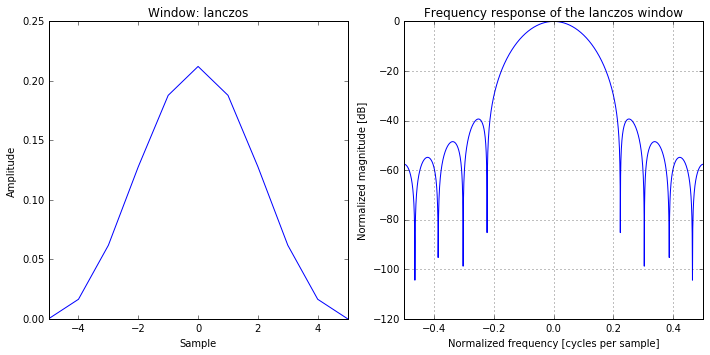

In [9]:
win1D.set(window_name='lanczos', n=[5], dims=['time_counter'], fc=0.1)
print win1D
win1D.plot()

In [10]:
signal_LF_lcz = win1D.apply(compute=True)

[########################################] | 100% Completed |  0.6s


### Results

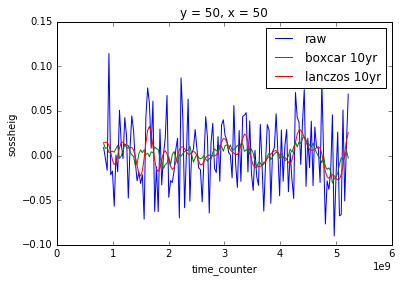

In [11]:
signal_xyt.isel(x=50, y=50).plot()
signal_LF_box.isel(x=50, y=50).plot(color='g')
signal_LF_lcz.isel(x=50, y=50).plot(color='r')
plt.legend(['raw', 'boxcar 10yr', 'lanczos 10yr'])

## 4. Spatial filtering
The window object extend to multidimensional filtering such bidimensional spatial filtering. The filtering method used is able to deal with missing data or coastline by reweighting the filters weights. For example, a 2D Lanczos window may thus be associated to a dataset.

In [12]:
signal_xyt = xr.open_dataset(sigdir + test_file, decode_times=False,engine='scipy')['sossheig'].chunk(chunks={'x': 40, 'y':40})
win_box2D = signal_xyt.win
win_box2D.set(window_name='lanczos', n=[24, 24], dims=['x', 'y'], fc=0.0416)
print signal_xyt
print win_box2D

<xarray.DataArray 'sossheig' (time_counter: 300, y: 184, x: 224)>
dask.array<xarray-..., shape=(300, 184, 224), dtype=float64, chunksize=(300, 40, 40)>
Coordinates:
  * time_counter  (time_counter) float64 73.04 nan nan nan nan nan nan nan ...
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Window [name->lanczos,dims->['x', 'y'],order->{'y': 24, 'x': 24}]


{1: 24, 2: 24}
(49, 49)


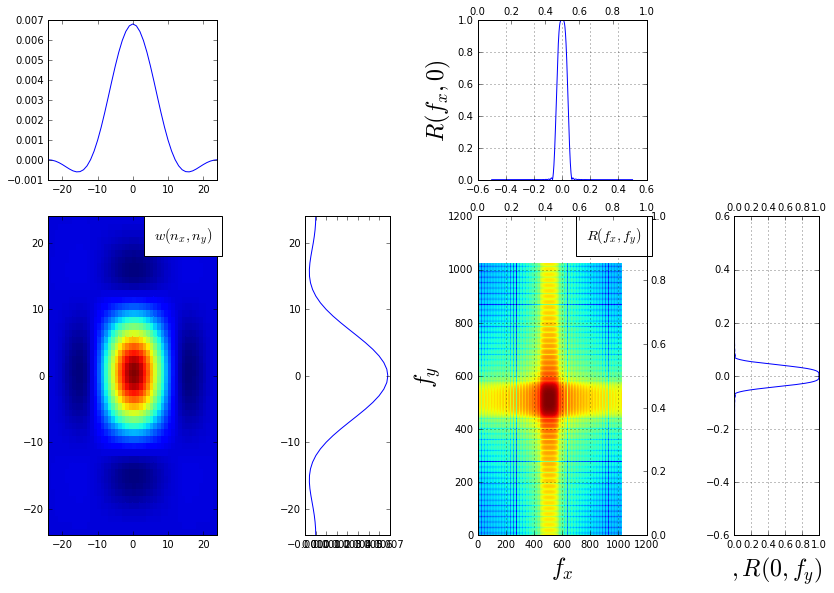

In [13]:
win_box2D.plot()

### original dataset
Temporal standard deviation of the raw timeseries:

In [14]:
bw = win_box2D.boundary_weights(drop_dims=[])

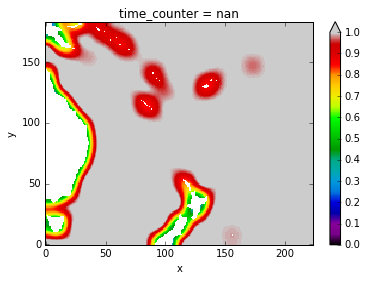

In [15]:
bw.isel(time_counter=1).plot(vmin=0, vmax=1, cmap='spectral')

In [16]:
signal_LS = win_box2D.apply(weights=bw)

[########################################] | 100% Completed |  2min  5.0s


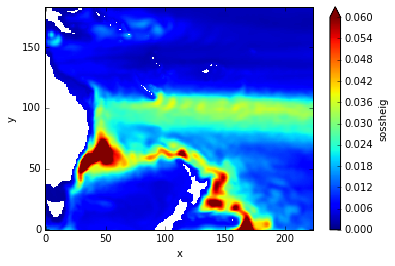

In [17]:
# Original dataset
signal_xyt.std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)

### large scales (>6°)
Temporal standard deviation of the large field:

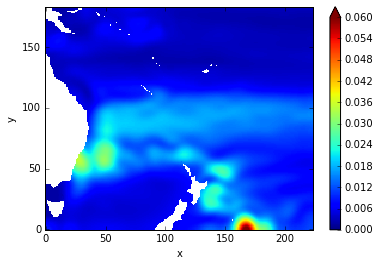

In [18]:
# Large-scale (>6°) dataset
signal_LS.std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)

### small scales (<6°)
Temporal standard deviation of the large field:

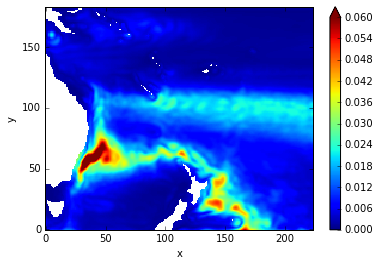

In [19]:
# Small-scale (<6°) dataset
(signal_xyt-signal_LS).std(dim='time_counter').plot(cmap='jet', vmin=0, vmax=0.06)

## 5. Concluding remarks 

Thanks to G. Serrazin, `oocgcm` library now provides methods for performing space and time filtering of model output based on `xarray` and `dask`. In the future, these tools will probably be transfered to [pangeo-data](https://pangeo-data.github.io/) toolbox.  